In [4]:
#instaliranje potrebne datoteke
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.5 MB/s eta 0:00:00


In [5]:
from Bio import SeqIO
import pandas as pd
import tensorflow as tf
import numpy as np
import random
import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
import math

In [6]:
#spajanje na google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
#Funkcija za učitavanje FASTA datoteke
def get_sequences_from_fasta(fasta_file):
    sequences = []
    with open(fasta_file, "r") as handle:
        for record in SeqIO.parse(handle, "fasta"):
            sequences.append(str(record.seq))
    return sequences



In [9]:
#funkcija za generiranje skupa podataka za treniranje i validaciju
data_length=500
korak=100
def getData(fasta_file,gff_file_path,podaci):

    sequence = get_sequences_from_fasta(fasta_file)[0]
    print(sequence[:500])

    #ucitavanje gff file-a
    columns = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
    GFF_DataFrame = pd.read_csv(gff_file_path, sep="\t", comment="#", names=columns)

    #stvaranje vektora koji određuje da li je baza dio gena ili nije
    gene_vector=tf.zeros(shape=len(sequence))
    print(gene_vector[:30])

    for index,row in GFF_DataFrame.iterrows():
        if(row["type"]=="gene"):


            start_position = row["start"]-1
            end_position = row["end"]-1


            mask = tf.concat([
                tf.zeros(start_position),
                tf.ones(end_position - start_position + 1),
                tf.zeros(gene_vector.shape[0] - end_position - 1)
            ], axis=0)


            gene_vector = gene_vector + mask


    gene_vector=gene_vector.numpy()
    for i in range(len(gene_vector)):
        if(gene_vector[i]!=0):
            gene_vector[i]=1
    gene_vector=tf.convert_to_tensor(gene_vector)



    #dijeljenje sekvence na dijelove
    for i in range(math.ceil(len(sequence)/korak)):
        slice_of_seq=sequence[i*korak:i*korak+data_length]
        slice_of_vector=gene_vector[i*korak:i*korak+data_length]

        if(len(slice_of_vector)!=data_length):

            start=(i*korak-len(sequence))
            end=i*korak+data_length-len(sequence)

            #loop around - spaja kraj i pocetak jer je DNA kružna
            slice_of_seq=sequence[start:] + sequence[:end]
            slice_of_vector=tf.concat([gene_vector[start:], gene_vector[:end]], axis=0)

        podaci.append((slice_of_seq,slice_of_vector))
    print("DONE with procesing data")
    return podaci


In [11]:
#dohvaćanje podataka sa google drive-a
import os
train_data=[]
val_data=[]
isFirst=True
cwd = os.getcwd()
folder_path = "/content/drive/MyDrive/Gene_annotations"



gene_annotations = os.listdir(folder_path)


for bacteria_name in gene_annotations:

    folder_path="/content/drive/MyDrive" +"/Gene_annotations/"+bacteria_name+"/data"

    files_in_annotations = os.listdir(folder_path)

    for gca_file in files_in_annotations:


        if(gca_file.startswith("GCA")):
            folder_path="/content/drive/MyDrive"+"/Gene_annotations/"+bacteria_name+"/data/"+gca_file

            gca_files = os.listdir(folder_path)

            for file in gca_files:

                if(file.startswith("GCA")):
                    fasta_file="/content/drive/MyDrive/"+"Gene_annotations/"+bacteria_name+"/data/"+gca_file+"/"+file

                if(file=="genomic.gff"):
                    gff_file_path="/content/drive/MyDrive/"+"Gene_annotations/"+bacteria_name+"/data/"+gca_file+"/"+file
    print("\nProcessing data for "+ bacteria_name+"\n")
    if(isFirst):
      val_data=getData(fasta_file,gff_file_path,val_data)
      isFirst=False
    else:
      train_data=getData(fasta_file,gff_file_path,train_data)







Processing data for Lysinibacillus_fusiformis

TTTTTATCTAAAATCAATTTAGGCTTATAGAGATCTTTATCAGAAGACTTGATCATAAATGAAATAGTTCTTTTACAGCAATCTCTACTTTGTCTTCTTTACCTTTTGTCACTTTTACTGTTTTTGATCTTTAAACGTATAGTTTGCTGGTAAAATCTCTTGTTTTGAGAATTGTGAAAAACCATAGTTAAATAATTTTGCTGTTGCATCAAAACGAGCTTTATATGACCCTTGTCCACTTGCATCAACAGCCTTCATGACCACTGCAATTAATCGAGTACCATTCCGTTCTGCAGTACCAGTGAAGCAATGGCCTGCAAAGTTTGTAGTACCAGTTTTTAATCCATCTACACCTTGATATTCAAAAACTAACCCTGGTAACATAAAGTTCCAGTTAGACATTTCAATGGCATCCTCTGTACCTTCACGGAATGTCTTTTTAGTAATTTGAGAAGTTTCTAATACCTTTGGGTGGTCCTTTAATAGATGGTAGGCAAGTT
        seqid            source        type  start      end score strand  \
0  CP010820.1           Genbank      region      1  4843789     .      +   
1  CP010820.1  Protein Homology  pseudogene      3     1089     .      -   
2  CP010820.1           Genbank        gene   1243     2706     .      -   
3  CP010820.1  Protein Homology         CDS   1243     2706     .      -   
4  CP010820.1           Genbank        gene   3010     3125     .      

In [12]:
#mjesanje i stvaranje seta za treniranje i validaciju
random.shuffle(val_data)
random.shuffle(train_data)

(train_seq, train_vector) = zip(*train_data)
(val_seq, val_vector) = zip(*val_data)

print("Veličina skupa za treniranje: " + str(len(train_data)))
print("Veličina skupa za validaciju: " + str(len(val_data)))
print("DONE")

145642
145642
48438
DONE


In [13]:
#kreiranje dataseta

train_seq=np.array(train_seq)
train_vector=np.array(train_vector)
val_seq=np.array(val_seq)
val_vector=np.array(val_vector)

train_dataset = tf.data.Dataset.from_tensor_slices((train_seq, train_vector)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_seq, val_vector)).batch(32)

print("Duljina dataseta za treniranje: " + str(len(train_dataset)))
print("DONE")

CCTAGGTACGCTCTTGCAGTCACTGTAGCC
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], shape=(30,), dtype=float32)
145642
145642
4552
DONE


In [14]:
#custom split funkcija
def custom_split_fn(string_tensor):
    return tf.strings.unicode_split(string_tensor, 'UTF-8')

print(custom_split_fn("ACAAGTTAC"))
print("DONE")

tf.Tensor([b'A' b'C' b'A' b'A' b'G' b'T' b'T' b'A' b'C'], shape=(9,), dtype=string)
DONE


In [15]:
#sloj za vekotrizaciju teksta

text_vectorization= TextVectorization(
    output_mode="int",
    split=custom_split_fn,
    output_sequence_length=data_length,
)
dataset=["ACGTTTGAGTCCAT"]
text_vectorization.adapt(dataset)
print(text_vectorization.get_vocabulary())
print("DONE")

['', '[UNK]', 't', 'g', 'c', 'a']
DONE


In [16]:
#vektoriziranje dataseta
int_train_ds= train_dataset.map(
    lambda x,y: (text_vectorization(x)-2,y),
    num_parallel_calls=4
)
int_validation_ds= validation_dataset.map(
    lambda x,y: (text_vectorization(x)-2,y),
    num_parallel_calls=4
)
print("DONE")

DONE


In [17]:
for inputs, targets in int_train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("inputs[0]:", tf.one_hot(inputs[0], depth=4))
  break

inputs.shape: (32, 500)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32, 500)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor(
[3 1 2 3 2 2 2 3 3 0 2 2 2 0 3 0 1 0 2 0 3 0 2 2 1 1 3 2 3 3 0 2 0 1 2 2 1
 2 1 1 1 0 1 3 3 0 1 2 2 2 3 2 1 1 0 1 1 3 2 2 2 1 1 1 1 1 2 2 1 3 2 2 1 1
 1 2 0 1 2 0 1 1 2 3 1 3 2 1 3 0 2 3 2 2 2 1 1 1 3 1 2 0 1 0 1 1 2 2 1 1 2
 3 2 2 2 0 3 0 2 0 1 1 0 1 3 0 1 1 3 2 3 2 2 1 1 0 1 2 2 3 1 2 2 0 2 1 2 3
 2 2 1 0 3 2 3 3 2 2 3 2 1 0 2 1 3 1 2 0 2 1 1 2 2 3 3 2 2 1 3 0 1 0 0 2 3
 2 0 1 3 3 0 3 2 1 0 3 0 1 1 1 1 3 2 1 2 2 3 3 0 3 2 1 1 3 1 3 1 3 3 2 3 2
 1 3 0 2 3 3 2 2 2 3 0 1 3 3 3 3 2 2 3 2 3 1 1 2 3 2 3 3 2 0 3 0 2 3 3 3 2
 0 2 1 1 2 3 0 2 1 0 2 0 1 1 0 0 1 1 0 1 2 0 1 0 2 1 1 0 1 0 0 2 3 2 2 1 0
 1 3 0 1 3 0 2 3 0 2 1 0 1 1 0 1 0 0 2 1 1 1 2 3 1 1 0 1 2 1 1 0 0 2 2 3 0
 2 3 2 3 2 2 3 2 2 1 1 1 0 3 2 0 2 2 1 2 1 1 0 1 0 0 2 3 2 2 2 3 0 1 0 2 3
 1 2 1 1 1 2 0 1 2 1 1 1 2 2 1 1 1 2 3 3 0 0 0 1 0 2 2 1 2 1 2 0 1 2 1 1 1
 2 1 0 3 1 3 1 1 0 2 1 1 2 3 3 1 1 0 2 

In [19]:
#definiranje modela

inputs=keras.Input(shape=(None,),dtype="int64")
x=tf.one_hot(inputs,depth=4)
x=layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x=layers.Conv1D(128, 9, activation="relu", padding="same")(x)
x=layers.Conv1D(128, 27, activation="relu", padding="same")(x)
x=layers.Dropout(0.5)(x)
x=layers.Bidirectional(layers.LSTM(256,return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(128,return_sequences=True))(x)
x=layers.TimeDistributed(layers.Dense(128,activation="relu"))(x)
x=layers.TimeDistributed(layers.Dense(64,activation="relu"))(x)
x=layers.TimeDistributed(layers.Dense(32,activation="relu"))(x)

outputs=layers.TimeDistributed(layers.Dense(1,activation="sigmoid"))(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])
callbacks=[
    keras.callbacks.ModelCheckpoint("upgraded_trained_model",
                                   save_best_only=True)
]

print("DONE")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 4)           0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          832       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         73856     
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         442496    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 512)         788480

In [20]:
#treniranje modela
history = model.fit(
        int_train_ds,
        epochs=15,
        batch_size=32,
        validation_data=int_validation_ds,
        callbacks=callbacks)
print("DONE")

Epoch 1/15
4552/4552 [==============================] - 589s 126ms/step - loss: 0.2659 - accuracy: 0.9032 - val_loss: 0.3600 - val_accuracy: 0.8807
Epoch 2/15
4552/4552 [==============================] - 593s 130ms/step - loss: 0.1839 - accuracy: 0.9313 - val_loss: 0.3388 - val_accuracy: 0.8916
Epoch 3/15
4552/4552 [==============================] - 572s 126ms/step - loss: 0.1444 - accuracy: 0.9461 - val_loss: 0.3554 - val_accuracy: 0.8981
Epoch 4/15
4552/4552 [==============================] - 570s 125ms/step - loss: 0.1184 - accuracy: 0.9554 - val_loss: 0.3626 - val_accuracy: 0.8983
Epoch 5/15
4552/4552 [==============================] - 571s 125ms/step - loss: 0.1091 - accuracy: 0.9586 - val_loss: 0.3691 - val_accuracy: 0.9036
Epoch 6/15
4552/4552 [==============================] - 570s 125ms/step - loss: 0.0927 - accuracy: 0.9646 - val_loss: 0.4026 - val_accuracy: 0.9145
Epoch 7/15
4552/4552 [==============================] - 570s 125ms/step - loss: 0.1124 - accuracy: 0.9565 - val_

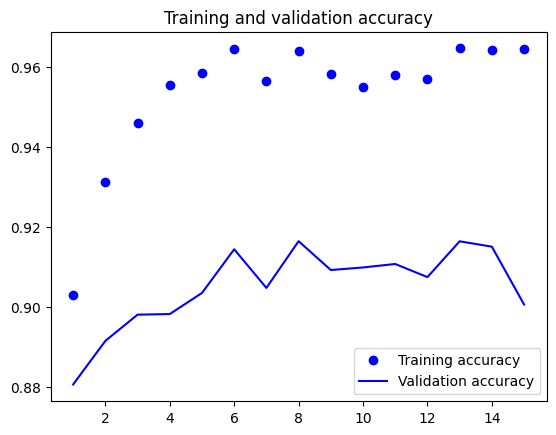

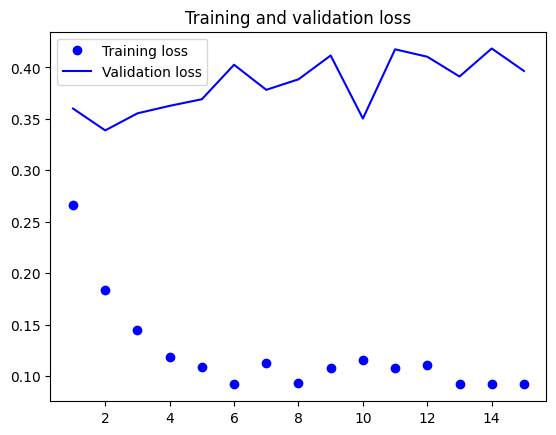

In [21]:
#crtanje grafova za točnost i loss
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [22]:
#spremanje istreniranog modela na google drive
from google.colab import files
best_model = tf.keras.models.load_model('upgraded_trained_model')

export_dir = '/content/drive/MyDrive/upgraded_trained_model'
best_model.save(export_dir)
print("Model je spremljen")